In [1]:
import numpy as np
from iminuit import Minuit

import constants, functions

from functools import partial

from joblib import Parallel, delayed

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [9]:
z_data = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)

z_data_panth = np.asarray(constants.z_data_panth)
is_calibrator_panth = np.asarray(constants.is_calibrator_panth)
m_b_corr_panth = np.asarray(constants.m_b_corr_panth)
ceph_dist_panth = np.asarray(constants.ceph_dist_panth)
inv_cov_panth = np.asarray(constants.inv_cov_panth)
n_panth = constants.n_panth
c = constants.C

chi2_func = partial(
    functions.chi2_rsd_panth,
    z_data,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth
)

n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

minimizer = Minuit(chi2_func, omega=0.315, sigma=0.811, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)

minimizer.limits["omega"] = (om_min,om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
minimizer.fixed["H0"] = True
minimizer.fixed["M"] = True
minimizer.fixed["c"] = True

result = minimizer.migrad()

In [7]:
print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.10f} ± {minimizer.errors['omega']:.10f}")
print(f"σ8,0 = {minimizer.values['sigma']:.10f} ± {minimizer.errors['sigma']:.10f}")
print(f"γ = {minimizer.values['gamma']:.10f} ± {minimizer.errors['gamma']:.10f}\n")
print(f"H0 = {minimizer.values['H0']:.10f} ± {minimizer.errors['H0']:.10f}")
print(f"M = {minimizer.values['M']:.10f} ± {minimizer.errors['M']:.10f}")

print(result)


Résultats du fit :
Chi2 = 1598.06 

Paramètres estimés :
Ωm = 0.3159400556 ± 0.0094539970
σ8,0 = 0.7436796816 ± 0.0480996234
γ = 0.4773591151 ± 0.1105421060

H0 = 73.4000000000 ± 0.7340000000
M = -19.2500000000 ± 0.1925000000
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1598                       │              Nfcn = 69               │
│ EDM = 6.29e-07 (Goal: 0.0002)    │            time = 2.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│            

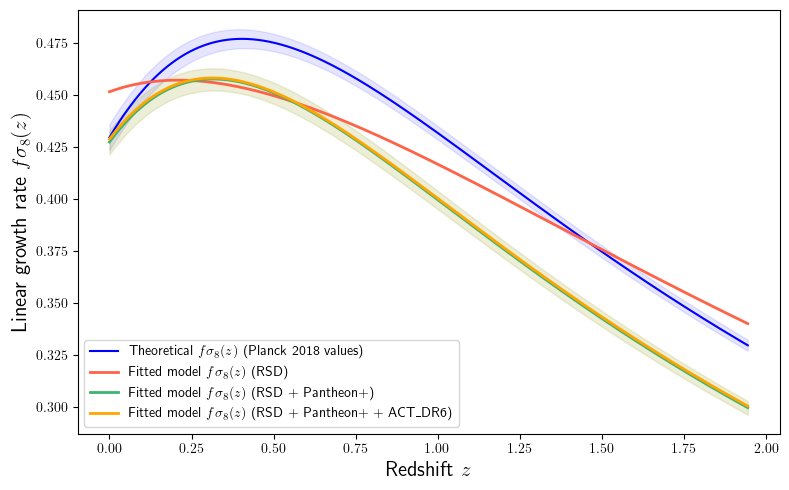

In [8]:
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

################################ Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(constants.z_data), max(constants.z_data), nb_points_th)

# Values found
sigma_8_0_rsd = (0.5373737373737374 + 0.5292929292929294) / 2
sigma_8_0_rsd_err = abs(sigma_8_0_rsd - (0.465 + 0.78)/2)
omega_0_rsd = (0.05 + 0.05) / 2
omega_0_rsd_err = abs(omega_0_rsd - (0.05 + 0.42)/2)
gamma_rsd = (0.05555555555555558 + 0.05555555555555558) / 2
gamma_rsd_err = abs(gamma_rsd - (0.01 + 0.725)/2)

sigma_8_0_panth = (0.7555555555555555 + 0.7474747474747475) / 2
sigma_8_0_panth_err = abs(sigma_8_0_panth - (0.69 + 0.83)/2)
omega_0_panth = (0.35707070707070704 + 0.35707070707070704) / 2
omega_0_panth_err = abs(omega_0_panth - (0.33 + 0.38)/2)
gamma_panth = (0.5606060606060606 + 0.5353535353535352) / 2
gamma_panth_err = abs(gamma_panth - (0.37 + 0.74)/2)

sigma_8_0_act = (0.7555555555555555 + 0.7428571428571429) / 2
sigma_8_0_act_err = abs(sigma_8_0_act - (0.69 + 0.825)/2)
omega_0_act = (0.34747474747474744 + 0.34747474747474744) / 2
omega_0_act_err = abs(omega_0_act - (0.34 + 0.36)/2)
gamma_act = (0.5353535353535352 + 0.5204081632653061) / 2
gamma_act_err = abs(gamma_act - (0.37 + 0.67)/2)

################################ Bootstrap

### Theoretical
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = functions.growth(z_range, omega_0 = omega0, sigma_8_0 = sigma8_0, gamma=0.55)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)

### RSD
fsigma8_rsd_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(omega_0_rsd, omega_0_rsd_err)
    while omega0 < 0:
        omega0 = np.random.normal(omega_0_rsd, omega_0_rsd_err)
    sigma8_0 = np.random.normal(sigma_8_0_rsd, sigma_8_0_rsd_err)
    gamma = np.random.normal(gamma_rsd, gamma_rsd_err)
    while gamma < 0:
        gamma = np.random.normal(gamma_rsd, gamma_rsd_err)
    fsigma8_rsd_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_mean, fsigma8_rsd_std = np.mean(fsigma8_rsd_boot, axis=0), np.std(fsigma8_rsd_boot, axis=0)

### RSD + Pantheon+
fsigma8_rsd_panth_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(omega_0_panth, omega_0_panth_err)
    sigma8_0 = np.random.normal(sigma_8_0_panth, sigma_8_0_panth_err)
    gamma = np.random.normal(gamma_panth, gamma_panth_err)
    fsigma8_rsd_panth_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_panth_mean, fsigma8_rsd_panth_std = np.mean(fsigma8_rsd_panth_boot, axis=0), np.std(fsigma8_rsd_panth_boot, axis=0)

### RSD + Pantheon+ + ACT_DR6
fsigma8_rsd_panth_act_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(omega_0_act, omega_0_act_err)
    sigma8_0 = np.random.normal(sigma_8_0_act, sigma_8_0_act_err)
    gamma = np.random.normal(gamma_act, gamma_act_err)
    fsigma8_rsd_panth_act_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_panth_act_mean, fsigma8_rsd_panth_act_std = np.mean(fsigma8_rsd_panth_boot, axis=0), np.std(fsigma8_rsd_panth_boot, axis=0)

################################ Approximation


fs8_approx_rsd = functions.growth(z_range, gamma=gamma_rsd, omega_0=omega_0_rsd, sigma_8_0=sigma_8_0_rsd)
fs8_approx_rsd_panth = functions.growth(z_range, gamma=gamma_panth, omega_0=omega_0_panth, sigma_8_0=sigma_8_0_panth)
fs8_approx_rsd_panth_act = functions.growth(z_range, gamma=gamma_act, omega_0=omega_0_act, sigma_8_0=sigma_8_0_act)

################################ Plotting

plt.figure(figsize=(8, 5))

growth_values = functions.growth(z_range, gamma=0.55, omega_0=constants.OMEGA_0, sigma_8_0=constants.SIGMA_8_0)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$ (Planck 2018 values)")
plt.fill_between(z_range, fsigma8_mean-fsigma8_std,
                            fsigma8_mean+fsigma8_std,
                color='blue', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd, color='tomato', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD)")
# plt.fill_between(z_range, fsigma8_rsd_mean - fsigma8_rsd_std,
#                              fsigma8_rsd_mean + fsigma8_rsd_std,
#                  color='tomato', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd_panth, color='mediumseagreen', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD + Pantheon+)")
plt.fill_between(z_range, fsigma8_rsd_panth_mean - fsigma8_rsd_panth_std,
                             fsigma8_rsd_panth_mean + fsigma8_rsd_panth_std,
                 color='mediumseagreen', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd_panth_act, color='orange', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD + Pantheon+ + ACT_DR6)")
plt.fill_between(z_range, fsigma8_rsd_panth_act_mean - fsigma8_rsd_panth_act_std,
                             fsigma8_rsd_panth_act_mean + fsigma8_rsd_panth_act_std,
                 color='orange', alpha=0.1)

# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.rcParams.update({
    "text.usetex": True
})
plt.show()

In [13]:
from time import time

### A run sans avoir run le précédent bloc.

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

# t = time()
# chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
# chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
# np.savez("../output/chi2_SN1a/chi2_grid1.npz", grid1=chi2_grid1)
# t = time() - t
# print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_func) for omega in omega_vals for gamma in gamma_vals)
# chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
# np.savez("../output/chi2_SN1a/chi2_grid2.npz", grid2=chi2_grid2)
# t = time() - t
# print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

t = time()
chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(sigma, gamma, om_min, om_max, chi2_func) for sigma in sigma_vals for gamma in gamma_vals)
chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
np.savez("../output/chi2_SN1a/chi2_grid3.npz", grid3=chi2_grid3)
t = time() - t
print("chi2_grid 3 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 3 calculated in 2 min 48.9 s.


### Load data

In [4]:
om_min = .05
om_max = 1

s8_min = 0.4
s8_max = 1.2

gamma_min = -0.5
gamma_max = 2

data = np.load("../output/chi2_SN1a/chi2_grids.npz")

chi2_grid1 = data['grid1']
chi2_grid2 = data['grid2']
chi2_grid3 = data['grid3']

### Confidence contours plot

(0.7555555555555555, 0.35353535353535354)
Incertitude $\sigma_8$ : xmin = 0.69, xmax = 0.83 : (+0.07, -0.07)
Incertitude $\Omega_m$ : ymin = 0.33, ymax = 0.38 : (+0.03, -0.03)

(0.5454545454545454, 0.35353535353535354)
Incertitude $\gamma$ : xmin = 0.36, xmax = 0.74 : (+0.18, -0.19)
Incertitude $\Omega_m$ : ymin = 0.33, ymax = 0.38 : (+0.03, -0.03)

(0.5454545454545454, 0.7555555555555555)
Incertitude $\gamma$ : xmin = 0.36, xmax = 0.74 : (+0.18, -0.19)
Incertitude $\sigma_8$ : ymin = 0.69, ymax = 0.83 : (+0.07, -0.07)



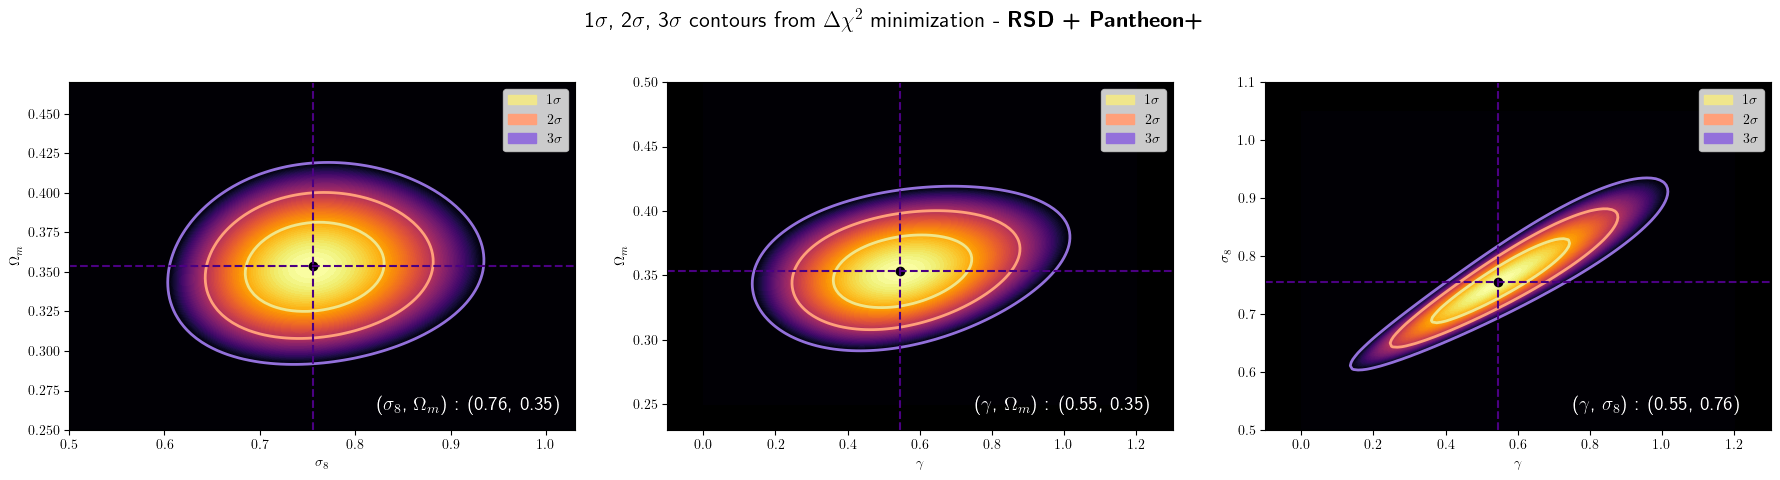

In [20]:
def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        
        sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[0]))
        omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
        gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[0]))

        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
                verticalalignment='top', horizontalalignment='left')

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

        ax.set_facecolor('black')

        if axis == 0:
            ax.set_xlim([0.5, 1.03])
            ax.set_ylim([0.25, 0.47])
        elif axis == 1:
            ax.set_xlim([-.1, 1.3])
            ax.set_ylim([0.23, 0.5])
        elif axis == 2:
            ax.set_xlim([-0.1, 1.3])
            ax.set_ylim([0.5, 1.1])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({
    "text.usetex": True
})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{RSD + Pantheon+}$", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
